In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
%matplotlib inline
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# World Trend in EV Sales
Load historical EV sales by Country

In [2]:
# Import Historical EV sales
EV_df = pd.read_csv(
    Path("./Data/EVHistorical.csv"), infer_datetime_format=True, parse_dates=True)
EV_df.head()

,region,powertrain,year,value
0,Australia,BEV,2011,49
1,Australia,BEV,2012,220
2,Australia,PHEV,2012,80
3,Australia,PHEV,2013,180
4,Australia,BEV,2013,410


In [3]:
EV_world_df = EV_df[(EV_df["region"]=='World')]
EV_world_df.head()

,region,powertrain,year,value
607,World,BEV,2010,17000
608,World,PHEV,2010,400
609,World,BEV,2011,55000
610,World,PHEV,2011,9500
611,World,BEV,2012,120000


<AxesSubplot:xlabel='year', ylabel='value'>

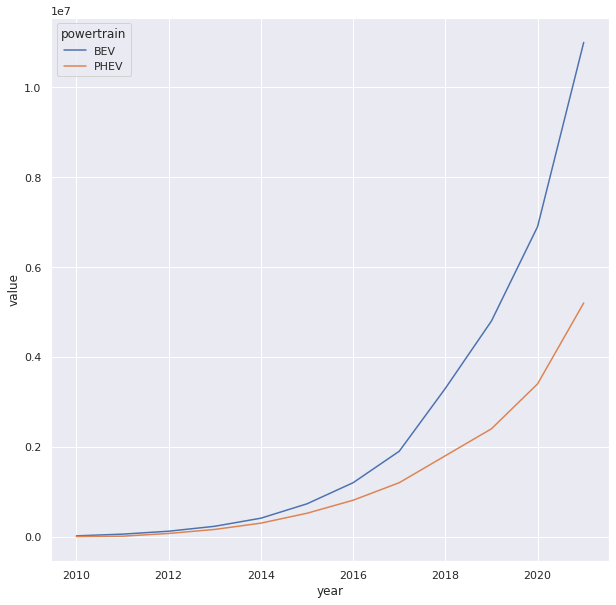

In [4]:
#define figure size
sns.set(rc={"figure.figsize":(10, 10)}) #width=6, height=5

# Plot just the "value" column from the dataframe:
sns.lineplot(data=EV_world_df, x="year", y="value", hue=EV_world_df["powertrain"])

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the World EV sales into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
bev_noise, bev_trend = sm.tsa.filters.hpfilter(EV_world_df[EV_world_df['powertrain']=='BEV'].set_index('year')["value"])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
EV_world_BEV_filter = EV_world_df[EV_world_df['powertrain']=='BEV'].copy().set_index('year')
EV_world_BEV_filter["noise"] = bev_noise
EV_world_BEV_filter["trend"] = bev_trend
EV_world_BEV_filter.head()

,region,powertrain,value,noise,trend
year,,,,,
2010,World,BEV,17000,1.929471e+06,-1.912471e+06
2011,World,BEV,55000,1.171754e+06,-1.116754e+06
2012,World,BEV,120000,4.398319e+05,-3.198319e+05
2013,World,BEV,230000,-2.502347e+05,4.802347e+05
2014,World,BEV,410000,-8.756587e+05,1.285659e+06


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='year'>

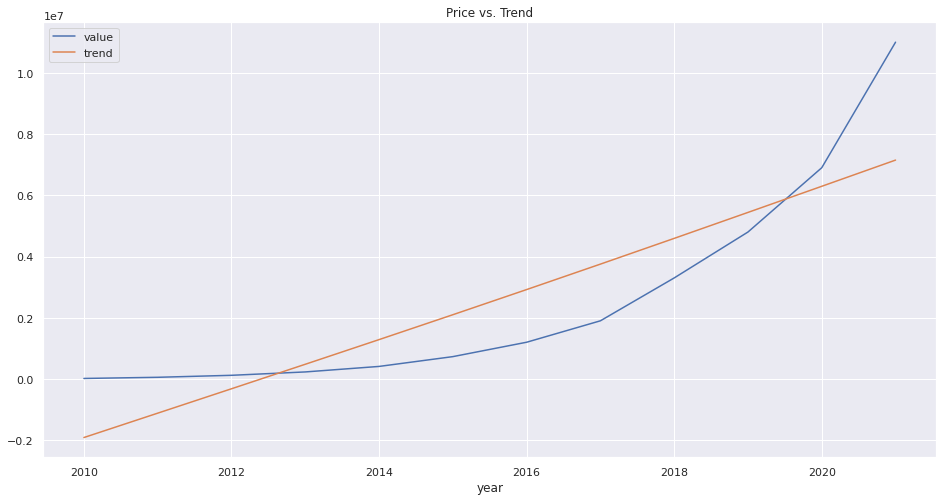

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
EV_world_BEV_filter[["value", "trend"]].plot(title="Price vs. Trend", figsize=(16, 8), xlabel="year")

Very noticeable uptrend.

# Forecasting US Sales by Model using Linear Regression

In [8]:
# Import Historical EV sales
EV_Models_df = pd.read_csv(
    Path("./Data/EVCars.csv"), infer_datetime_format=True, parse_dates=True)
EV_Models_df.head()

,Vehicle,Model,Make,Type,Year,Sales
0,Chevy Volt,Chevy,Volt,PHEV,2011,7671
1,Chevy Volt,Chevy,Volt,PHEV,2012,23461
2,Chevy Volt,Chevy,Volt,PHEV,2013,23094
3,Chevy Volt,Chevy,Volt,PHEV,2014,18805
4,Chevy Volt,Chevy,Volt,PHEV,2015,15393


In [9]:
EV_Models_df['pct_ch'] = EV_Models_df.groupby('Vehicle')['Sales'].apply(pd.Series.pct_change) * 100
EV_Models_df['Sales_Lag'] = EV_Models_df["Sales"].groupby(EV_Models_df['Vehicle']).shift(1)

EV_Models_df['pct_ch'] = EV_Models_df['pct_ch'].replace(-np.inf, np.nan)
EV_Models_df['pct_ch'] = EV_Models_df['pct_ch'].replace(np.inf, np.nan)
EV_Models_df['Sales_Lag'].replace(0, np.nan, inplace=True)
EV_Models_df.dropna(inplace=True)

EV_Models_df

,Vehicle,Model,Make,Type,Year,Sales,pct_ch,Sales_Lag
1,Chevy Volt,Chevy,Volt,PHEV,2012,23461,205.840177,7671.0
2,Chevy Volt,Chevy,Volt,PHEV,2013,23094,-1.564298,23461.0
3,Chevy Volt,Chevy,Volt,PHEV,2014,18805,-18.571923,23094.0
4,Chevy Volt,Chevy,Volt,PHEV,2015,15393,-18.144111,18805.0
5,Chevy Volt,Chevy,Volt,PHEV,2016,24739,60.715910,15393.0
...,...,...,...,...,...,...,...,...
404,Mitsubishi Outlander PHEV,Mitsubishi,Outlander PHEV,PHEV,2019,2810,-32.549208,4166.0
413,Hyundai IONIQ PHEV,Hyundai,IONIQ PHEV,PHEV,2019,1765,11.006289,1590.0
422,Kia Niro PHEV,Kia,Niro PHEV,PHEV,2019,4051,19.533786,3389.0
431,Mercedes GLC 350e,Mercedes,GLC 350e,PHEV,2019,2459,333.686067,567.0


In [10]:
new_EVs = EV_Models_df.groupby('Vehicle')['Model'].count().to_frame()
old_EVs = new_EVs[new_EVs['Model'] < 2]

In [11]:
#drop rows that contain any value in the list
EV_Models_df = EV_Models_df[(EV_Models_df['Vehicle'].isin(list(old_EVs.index)) == False) & (EV_Models_df['Year'] > 2011)]
EV_Models_df

,Vehicle,Model,Make,Type,Year,Sales,pct_ch,Sales_Lag
1,Chevy Volt,Chevy,Volt,PHEV,2012,23461,205.840177,7671.0
2,Chevy Volt,Chevy,Volt,PHEV,2013,23094,-1.564298,23461.0
3,Chevy Volt,Chevy,Volt,PHEV,2014,18805,-18.571923,23094.0
4,Chevy Volt,Chevy,Volt,PHEV,2015,15393,-18.144111,18805.0
5,Chevy Volt,Chevy,Volt,PHEV,2016,24739,60.715910,15393.0
...,...,...,...,...,...,...,...,...
377,Volvo XC60 PHEV,Volvo,XC60 PHEV,PHEV,2019,1682,-25.805029,2267.0
385,Volvo S90 T8 PHEV,Volvo,S90 T8 PHEV,PHEV,2018,437,290.178571,112.0
386,Volvo S90 T8 PHEV,Volvo,S90 T8 PHEV,PHEV,2019,407,-6.864989,437.0
394,Honda Clarity PHEV,Honda,Clarity PHEV,PHEV,2018,18602,1960.022148,903.0


In [12]:
#Compute market share for each EV model per year
EV_TotalSales = EV_Models_df.groupby('Year')['Sales'].sum().to_frame()
EV_TotalSales.rename(columns={'Sales':'Market_Sales'}, inplace = True)

EV_Models_df = EV_Models_df.merge(EV_TotalSales, left_on='Year', right_on='Year')
EV_Models_df['Market_Share'] = EV_Models_df['Sales']/EV_Models_df['Market_Sales'] * 100

EV_Models_df

,Vehicle,Model,Make,Type,Year,Sales,pct_ch,Sales_Lag,Market_Sales,Market_Share
0,Chevy Volt,Chevy,Volt,PHEV,2012,23461,205.840177,7671.0,33419,70.202579
1,Nissan Leaf,Nissan,Leaf,EV,2012,9819,1.498863,9674.0,33419,29.381490
2,Smart ED,Smart,ED,EV,2012,139,-59.356725,342.0,33419,0.415931
3,Chevy Volt,Chevy,Volt,PHEV,2013,23094,-1.564298,23461.0,88581,26.071054
4,Nissan Leaf,Nissan,Leaf,EV,2013,22610,130.267848,9819.0,88581,25.524661
...,...,...,...,...,...,...,...,...,...,...
178,Tesla Model 3,Tesla,Model 3,EV,2019,154840,10.772489,139782.0,303433,51.029387
179,Honda Clarity BEV,Honda,Clarity BEV,EV,2019,742,-21.729958,948.0,303433,0.244535
180,Volvo XC60 PHEV,Volvo,XC60 PHEV,PHEV,2019,1682,-25.805029,2267.0,303433,0.554323
181,Volvo S90 T8 PHEV,Volvo,S90 T8 PHEV,PHEV,2019,407,-6.864989,437.0,303433,0.134132


In [13]:
Vehicles = EV_Models_df[['Vehicle','Model','Make']].drop_duplicates()
VehicleSales_pred = pd.DataFrame(Vehicles,columns=['Vehicle','Model','Make']).set_index('Vehicle')

In [14]:
model = LinearRegression()

for v in Vehicles['Vehicle'].values:
    curr_EV = EV_Models_df[EV_Models_df['Vehicle']==v].set_index('Year', drop=False)

    X = curr_EV['Year'].values.reshape(-1, 1)
    y = curr_EV['Sales'].values
    
    model.fit(X, y)
    
    pred = [[2022],[2023]]

    y_pred = model.predict(pred)

    VehicleSales_pred.loc[v, '2022'] = y_pred[0]
    VehicleSales_pred.loc[v, '2023'] = y_pred[1]

VehicleSales_pred

,Model,Make,2022,2023
Vehicle,,,,
Chevy Volt,Chevy,Volt,7816.130952,6152.035714
Nissan Leaf,Nissan,Leaf,10194.976190,9220.857143
Smart ED,Smart,ED,893.059524,873.857143
Toyota Prius,Toyota,Prius,32032.500000,34890.821429
Ford Focus Electric,Ford,Focus Electric,-445.500000,-723.607143
Honda Fit EV,Honda,Fit EV,-1339.500000,-1550.700000
Tesla Model S,Tesla,Model S,23989.285714,24180.714286
Toyota Rav4 EV,Toyota,Rav4 EV,-2584.000000,-3002.100000
Ford C-Max Energi,Ford,C-Max Energi,-2152.214286,-3459.892857


In [15]:
VehiclePctCh_pred = VehicleSales_pred.copy()

for v in Vehicles['Vehicle'].values:
    curr_EV = EV_Models_df[EV_Models_df['Vehicle']==v].set_index('Year', drop=False)

    X = curr_EV['Year'].values.reshape(-1, 1)
    y = curr_EV['pct_ch'].values
    
    model.fit(X, y)
       
    pred = [[2022],[2023]]

    y_pred = model.predict(pred)    
    
    VehiclePctCh_pred.loc[v, '2022'] = y_pred[0]
    VehiclePctCh_pred.loc[v, '2023'] = y_pred[1]    

VehiclePctCh_pred

,Model,Make,2022,2023
Vehicle,,,,
Chevy Volt,Chevy,Volt,-132.187726,-154.973142
Nissan Leaf,Nissan,Leaf,-46.041377,-55.025929
Smart ED,Smart,ED,-127.357130,-159.435439
Toyota Prius,Toyota,Prius,272.246166,301.933603
Ford Focus Electric,Ford,Focus Electric,-167.502290,-196.311172
Honda Fit EV,Honda,Fit EV,-1358.929013,-1549.581159
Tesla Model S,Tesla,Model S,-390.634421,-472.641854
Toyota Rav4 EV,Toyota,Rav4 EV,-1204.260202,-1372.920520
Ford C-Max Energi,Ford,C-Max Energi,-235.187292,-274.945000


In [16]:
MarketShare_pred = VehicleSales_pred.copy()

for v in Vehicles['Vehicle'].values:
    curr_EV = EV_Models_df[EV_Models_df['Vehicle']==v].set_index('Year', drop=False)

    X = curr_EV['Year'].values.reshape(-1, 1)
    y = curr_EV['Market_Share'].values
    
    model.fit(X, y)
       
    pred = [[2022],[2023]]

    y_pred = model.predict(pred)    
    
    MarketShare_pred.loc[v, '2022'] = y_pred[0]
    MarketShare_pred.loc[v, '2023'] = y_pred[1]    

MarketShare_pred

,Model,Make,2022,2023
Vehicle,,,,
Chevy Volt,Chevy,Volt,-26.245450,-33.381694
Nissan Leaf,Nissan,Leaf,-12.212694,-16.421572
Smart ED,Smart,ED,-0.118644,-0.258767
Toyota Prius,Toyota,Prius,4.428038,3.781667
Ford Focus Electric,Ford,Focus Electric,-1.057791,-1.398165
Honda Fit EV,Honda,Fit EV,-1.467191,-1.696572
Tesla Model S,Tesla,Model S,-0.834858,-3.519221
Toyota Rav4 EV,Toyota,Rav4 EV,-2.789175,-3.235153
Ford C-Max Energi,Ford,C-Max Energi,-4.267689,-5.747604


In [17]:
VehiclePctCh_pred[VehiclePctCh_pred['2022'] > 0]

,Model,Make,2022,2023
Vehicle,,,,
Toyota Prius,Toyota,Prius,272.246166,301.933603
Porsche Panamera E-Hybrid,Porsche,Panamera E-Hybrid,6130.500288,6860.947236
Hyundai IONIQ EV,Hyundai,IONIQ EV,517.228261,651.570048


In [18]:
sales_forecast = VehicleSales_pred[(VehicleSales_pred['2023'] > 0) & 
                                   (VehicleSales_pred['2023'] >= VehicleSales_pred['2022'])]
sales_forecast

,Model,Make,2022,2023
Vehicle,,,,
Toyota Prius,Toyota,Prius,32032.500000,34890.821429
Tesla Model S,Tesla,Model S,23989.285714,24180.714286
Porsche Panamera E-Hybrid,Porsche,Panamera E-Hybrid,2505.314286,2788.371429
Mercedes S550e,Mercedes,S550e,1220.500000,1351.250000
Tesla Model X,Tesla,Model X,23450.000000,23837.500000
Mercedes C350e,Mercedes,C350e,4280.000000,4957.500000
Hyundai IONIQ EV,Hyundai,IONIQ EV,1921.000000,2315.000000
Tesla Model 3,Tesla,Model 3,200014.000000,215072.000000


In [19]:
mkt_share_forecast = MarketShare_pred[(MarketShare_pred['2023']>0)]
mkt_share_forecast

,Model,Make,2022,2023
Vehicle,,,,
Toyota Prius,Toyota,Prius,4.428038,3.781667
Porsche Panamera E-Hybrid,Porsche,Panamera E-Hybrid,0.387222,0.377367
Mercedes S550e,Mercedes,S550e,0.170602,0.147038
Mercedes C350e,Mercedes,C350e,1.085162,1.218546
Hyundai IONIQ EV,Hyundai,IONIQ EV,0.679490,0.824804
Chrysler Pacifica Hybrid,Chrysler,Pacifica Hybrid,1.628052,1.532374
Tesla Model 3,Tesla,Model 3,84.717189,95.946457
Honda Clarity BEV,Honda,Clarity BEV,0.168368,0.142979
Volvo XC60 PHEV,Volvo,XC60 PHEV,0.280845,0.189686


In [20]:
mkt_share_forecast2 = MarketShare_pred[(MarketShare_pred['2023']>0) & (MarketShare_pred['2023']>MarketShare_pred['2022'])]
mkt_share_forecast2

,Model,Make,2022,2023
Vehicle,,,,
Mercedes C350e,Mercedes,C350e,1.085162,1.218546
Hyundai IONIQ EV,Hyundai,IONIQ EV,0.679490,0.824804
Tesla Model 3,Tesla,Model 3,84.717189,95.946457
Volvo S90 T8 PHEV,Volvo,S90 T8 PHEV,0.163246,0.172951


In [21]:
import boto3
import csv
import io
import os
from dotenv import load_dotenv

In [22]:
# Load .env enviroment variables
load_dotenv()

# Set Alpaca API key and secret
aws_access_key_id = os.getenv("aws_access_key_id")
aws_secret_access_key = os.getenv("aws_secret_access_key")

In [23]:
session = boto3.Session(aws_access_key_id=aws_access_key_id,
                        aws_secret_access_key=aws_secret_access_key)

s3 = session.resource('s3')

In [24]:
csv_buffer = io.StringIO()
sales_forecast.to_csv(csv_buffer)
s3.Object('mj.samadi', 'ev_sales_forecast.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'T8TC79HM4DMFZRXS',
  'HostId': 'rivrqq5+pRoAbygim7Dj7I29ZwwGvzjNP0rcJ4j9KWxBPXgcjqTLG7Ai9THN3T865M0auFZoDJg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'rivrqq5+pRoAbygim7Dj7I29ZwwGvzjNP0rcJ4j9KWxBPXgcjqTLG7Ai9THN3T865M0auFZoDJg=',
   'x-amz-request-id': 'T8TC79HM4DMFZRXS',
   'date': 'Tue, 20 Sep 2022 18:12:51 GMT',
   'etag': '"5c82eb4088d6b8ff50e376cb33e1ad5d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5c82eb4088d6b8ff50e376cb33e1ad5d"'}

In [25]:
csv_buffer = io.StringIO()
mkt_share_forecast.to_csv(csv_buffer)
s3.Object('mj.samadi', 'ev_mkt_share_forecast.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'T8T0VHYS0CMZ7KCB',
  'HostId': 'Pa698FPLA/sDWREPxMwUCwxzy0jva2MEnmgLEVyZdhYNABvnKiuUSndP/Yl8ptawVNzBDaBmZrA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Pa698FPLA/sDWREPxMwUCwxzy0jva2MEnmgLEVyZdhYNABvnKiuUSndP/Yl8ptawVNzBDaBmZrA=',
   'x-amz-request-id': 'T8T0VHYS0CMZ7KCB',
   'date': 'Tue, 20 Sep 2022 18:12:51 GMT',
   'etag': '"c7a639ac5c7094fe311d18a6ab840441"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c7a639ac5c7094fe311d18a6ab840441"'}